# Ellipses

In [1]:
%matplotlib widget
import starepandas
import pystare
import matplotlib.pyplot as plt
import contextily
import geopandas
import copy
import numpy
import pandas

In [34]:
mod03_name = '../tests/data/granules/MOD03.A2017345.1925.006.2017346004924.hdf'
mod03 = starepandas.read_granule(mod03_name, sidecar_path='../tests/data/granules/MOD03.A2017345.1925.006.2017347015352_stare.nc', sidecar=True, xy=True)

In [35]:
mod03 = copy.copy(mod03[0:1354*3])

In [36]:
lat, lon = pystare.to_latlon(mod03.sids)
lon = lon - 360
geoms = geopandas.points_from_xy(x=lon,y=lat, crs=4326)
mod03.set_geometry(geoms, inplace=True)

# Make ellipses

In [39]:
ellipse_sids = starepandas.io.granules.modis.make_ellipse_sids(mod03, n_partitions=400, num_workers=7, level=17, crs=3857, modis_resolution=1000)
mod03['ellipse_sids'] = ellipse_sids

In [40]:
ellipse_trixels = mod03.make_trixels(sid_column='ellipse_sids', n_partitions=400, num_workers=7)
mod03['ellipse_trixels'] = ellipse_trixels

# Make circles

In [41]:
r_circle = 500
r_earth = 6563000
phi = r_circle /2/3.14/r_earth*360
phi

0.004367274170678897

In [42]:
circle_sids = starepandas.make_circular_sids(mod03, level=17, diameter=phi, n_partitions=400, num_workers=7)
mod03['circle_sids'] = circle_sids

In [43]:
cirlce_trixels = mod03.make_trixels(sid_column='circle_sids', n_partitions=400, num_workers=7)
mod03['circle_trixels'] = cirlce_trixels

# Plot

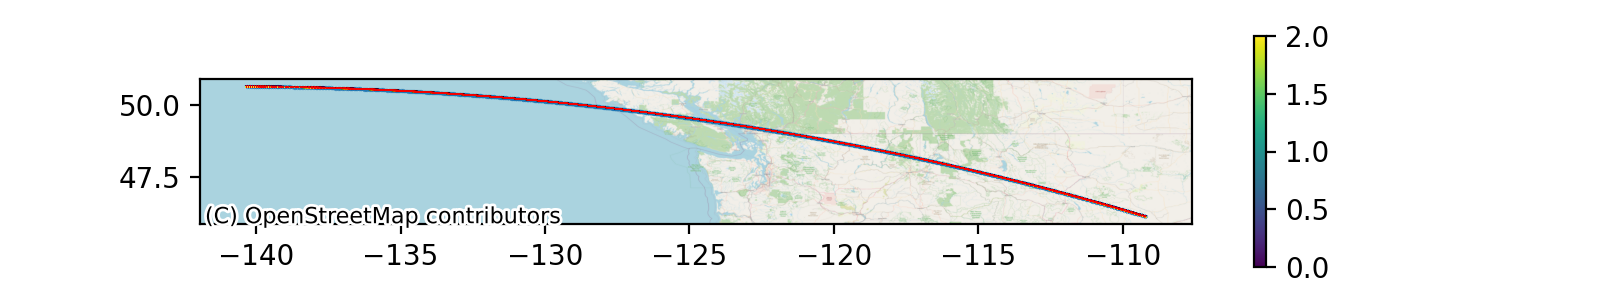

In [44]:
fig, ax = plt.subplots(figsize=(8,1.5), dpi=200)

mod03.set_trixels('ellipse_trixels').plot(ax=ax, trixels=True, boundary=True, column='x', legend=True, linewidth=0.1, zorder=2)
mod03.set_trixels('circle_trixels').plot(ax=ax, trixels=True, boundary=True,  linewidth=0.1, zorder=2, color='red')
mod03.plot(ax=ax, trixels=False, markersize=0.1, marker='.', zorder=1)
contextily.add_basemap(ax, source=contextily.providers.OpenStreetMap.Mapnik, crs=4326)

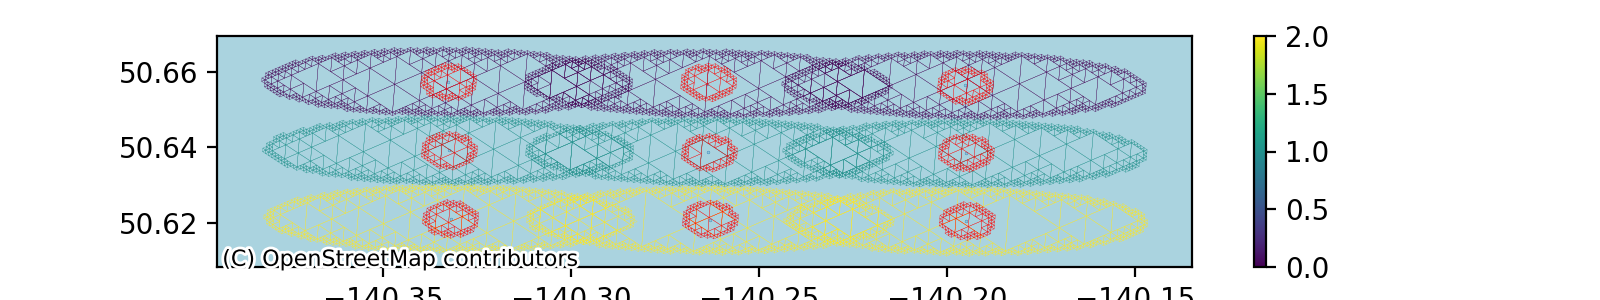

In [48]:
fig, ax = plt.subplots(figsize=(8,1.5), dpi=200)

subset = copy.copy(mod03[mod03.y<3])
subset.set_trixels('ellipse_trixels').plot(ax=ax, trixels=True, boundary=True, column='x', legend=True, linewidth=0.1, zorder=2)
subset.set_trixels('circle_trixels').plot(ax=ax, trixels=True, boundary=True,  linewidth=0.1, zorder=2, color='red')
subset.plot(ax=ax, trixels=False, markersize=0.1, marker='.', zorder=1)
contextily.add_basemap(ax, source=contextily.providers.OpenStreetMap.Mapnik, crs=4326)

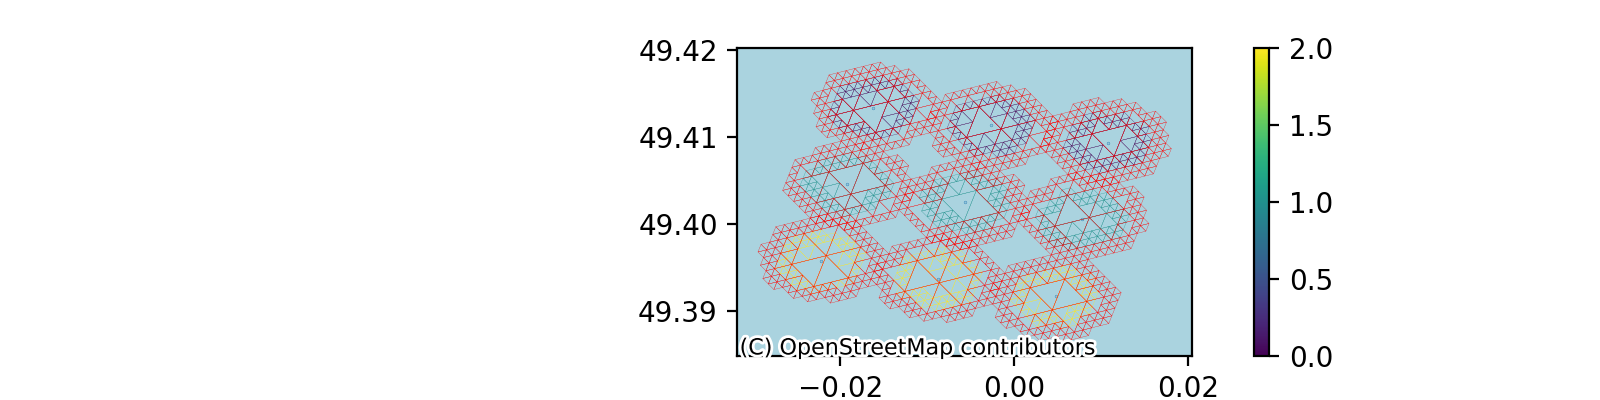

In [49]:
fig, ax = plt.subplots(figsize=(8,2), dpi=200)

subset = copy.copy(mod03[(mod03.y>=676) & (mod03.y<=678)])
subset.set_trixels('ellipse_trixels').plot(ax=ax, trixels=True, boundary=True, column='x', legend=True, linewidth=0.1, zorder=2)
subset.set_trixels('circle_trixels').plot(ax=ax, trixels=True, boundary=True,  linewidth=0.1, zorder=2, color='red')
subset.plot(ax=ax, trixels=False, markersize=0.1, marker='.', zorder=1)
contextily.add_basemap(ax, source=contextily.providers.OpenStreetMap.Mapnik, crs=4326)

# Fit Ellipse

In [50]:
deg = [0.,10,20,30,40,50,55]
scan_pts = [1, 1.05, 1.2, 1.5, 2, 3.2, 4.83]
trac_pts = [1, 1.028, 1.083, 1.193, 1.367, 1.688, 2.01]

In [51]:
def func(x, a, b, c):
    return numpy.exp(a*x)/b+c

In [52]:
from scipy.optimize import curve_fit
scan_params, cov = curve_fit(func, deg, scan_pts, bounds=(0, [1, 100, 1]))   
trac_params, cov = curve_fit(func, deg, trac_pts, bounds=(0, [1, 100, 1]))   

<AxesSubplot:xlabel='Scan Angle', ylabel='Distance'>

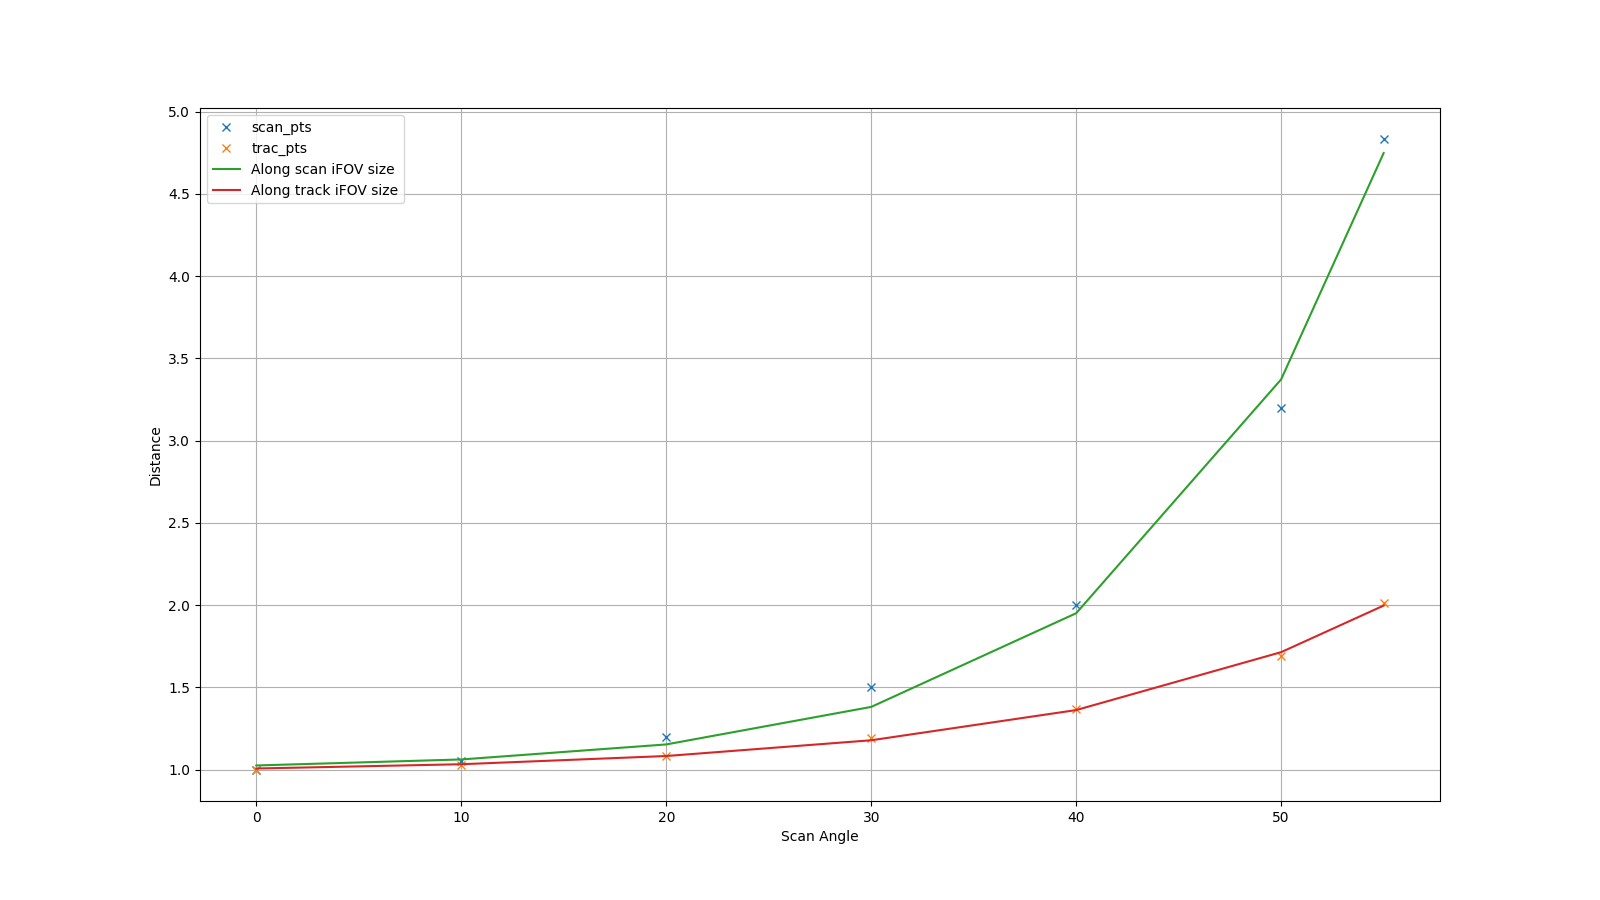

In [57]:
fig, ax = plt.subplots(figsize=(16,9), dpi=100)

df = pandas.DataFrame({'deg': deg, 'scan_pts': scan_pts, 'trac_pts': trac_pts})
df['Along scan iFOV size'] = numpy.exp(scan_params[0]*df['deg'])/scan_params[1]+scan_params[2]
df['Along track iFOV size'] = numpy.exp(trac_params[0]*df['deg'])/trac_params[1]+trac_params[2]

df.plot(ax=ax, x='deg', y=['scan_pts', 'trac_pts'], grid=True, ylabel='Distance', xlabel='Scan Angle', marker='x', linewidth=0)
df.plot(ax=ax, x='deg', y=['Along scan iFOV size', 'Along track iFOV size'], grid=True, ylabel='Distance', xlabel='Scan Angle')

# Some experiments

In [ ]:
ifov = mod03[1353:1353]
zenith = ifov.SensorZenith.iloc[0]
zenith

In [33]:
azimuth = ifov.SensorAzimuth.iloc[0]
azimuth

-66.95

In [34]:
width = starepandas.io.granules.modis.zenith2width(zenith)*1000
width

10633.804753081185

In [35]:
height = starepandas.io.granules.modis.zenith2height(zenith)*1000
height

2972.51207426483

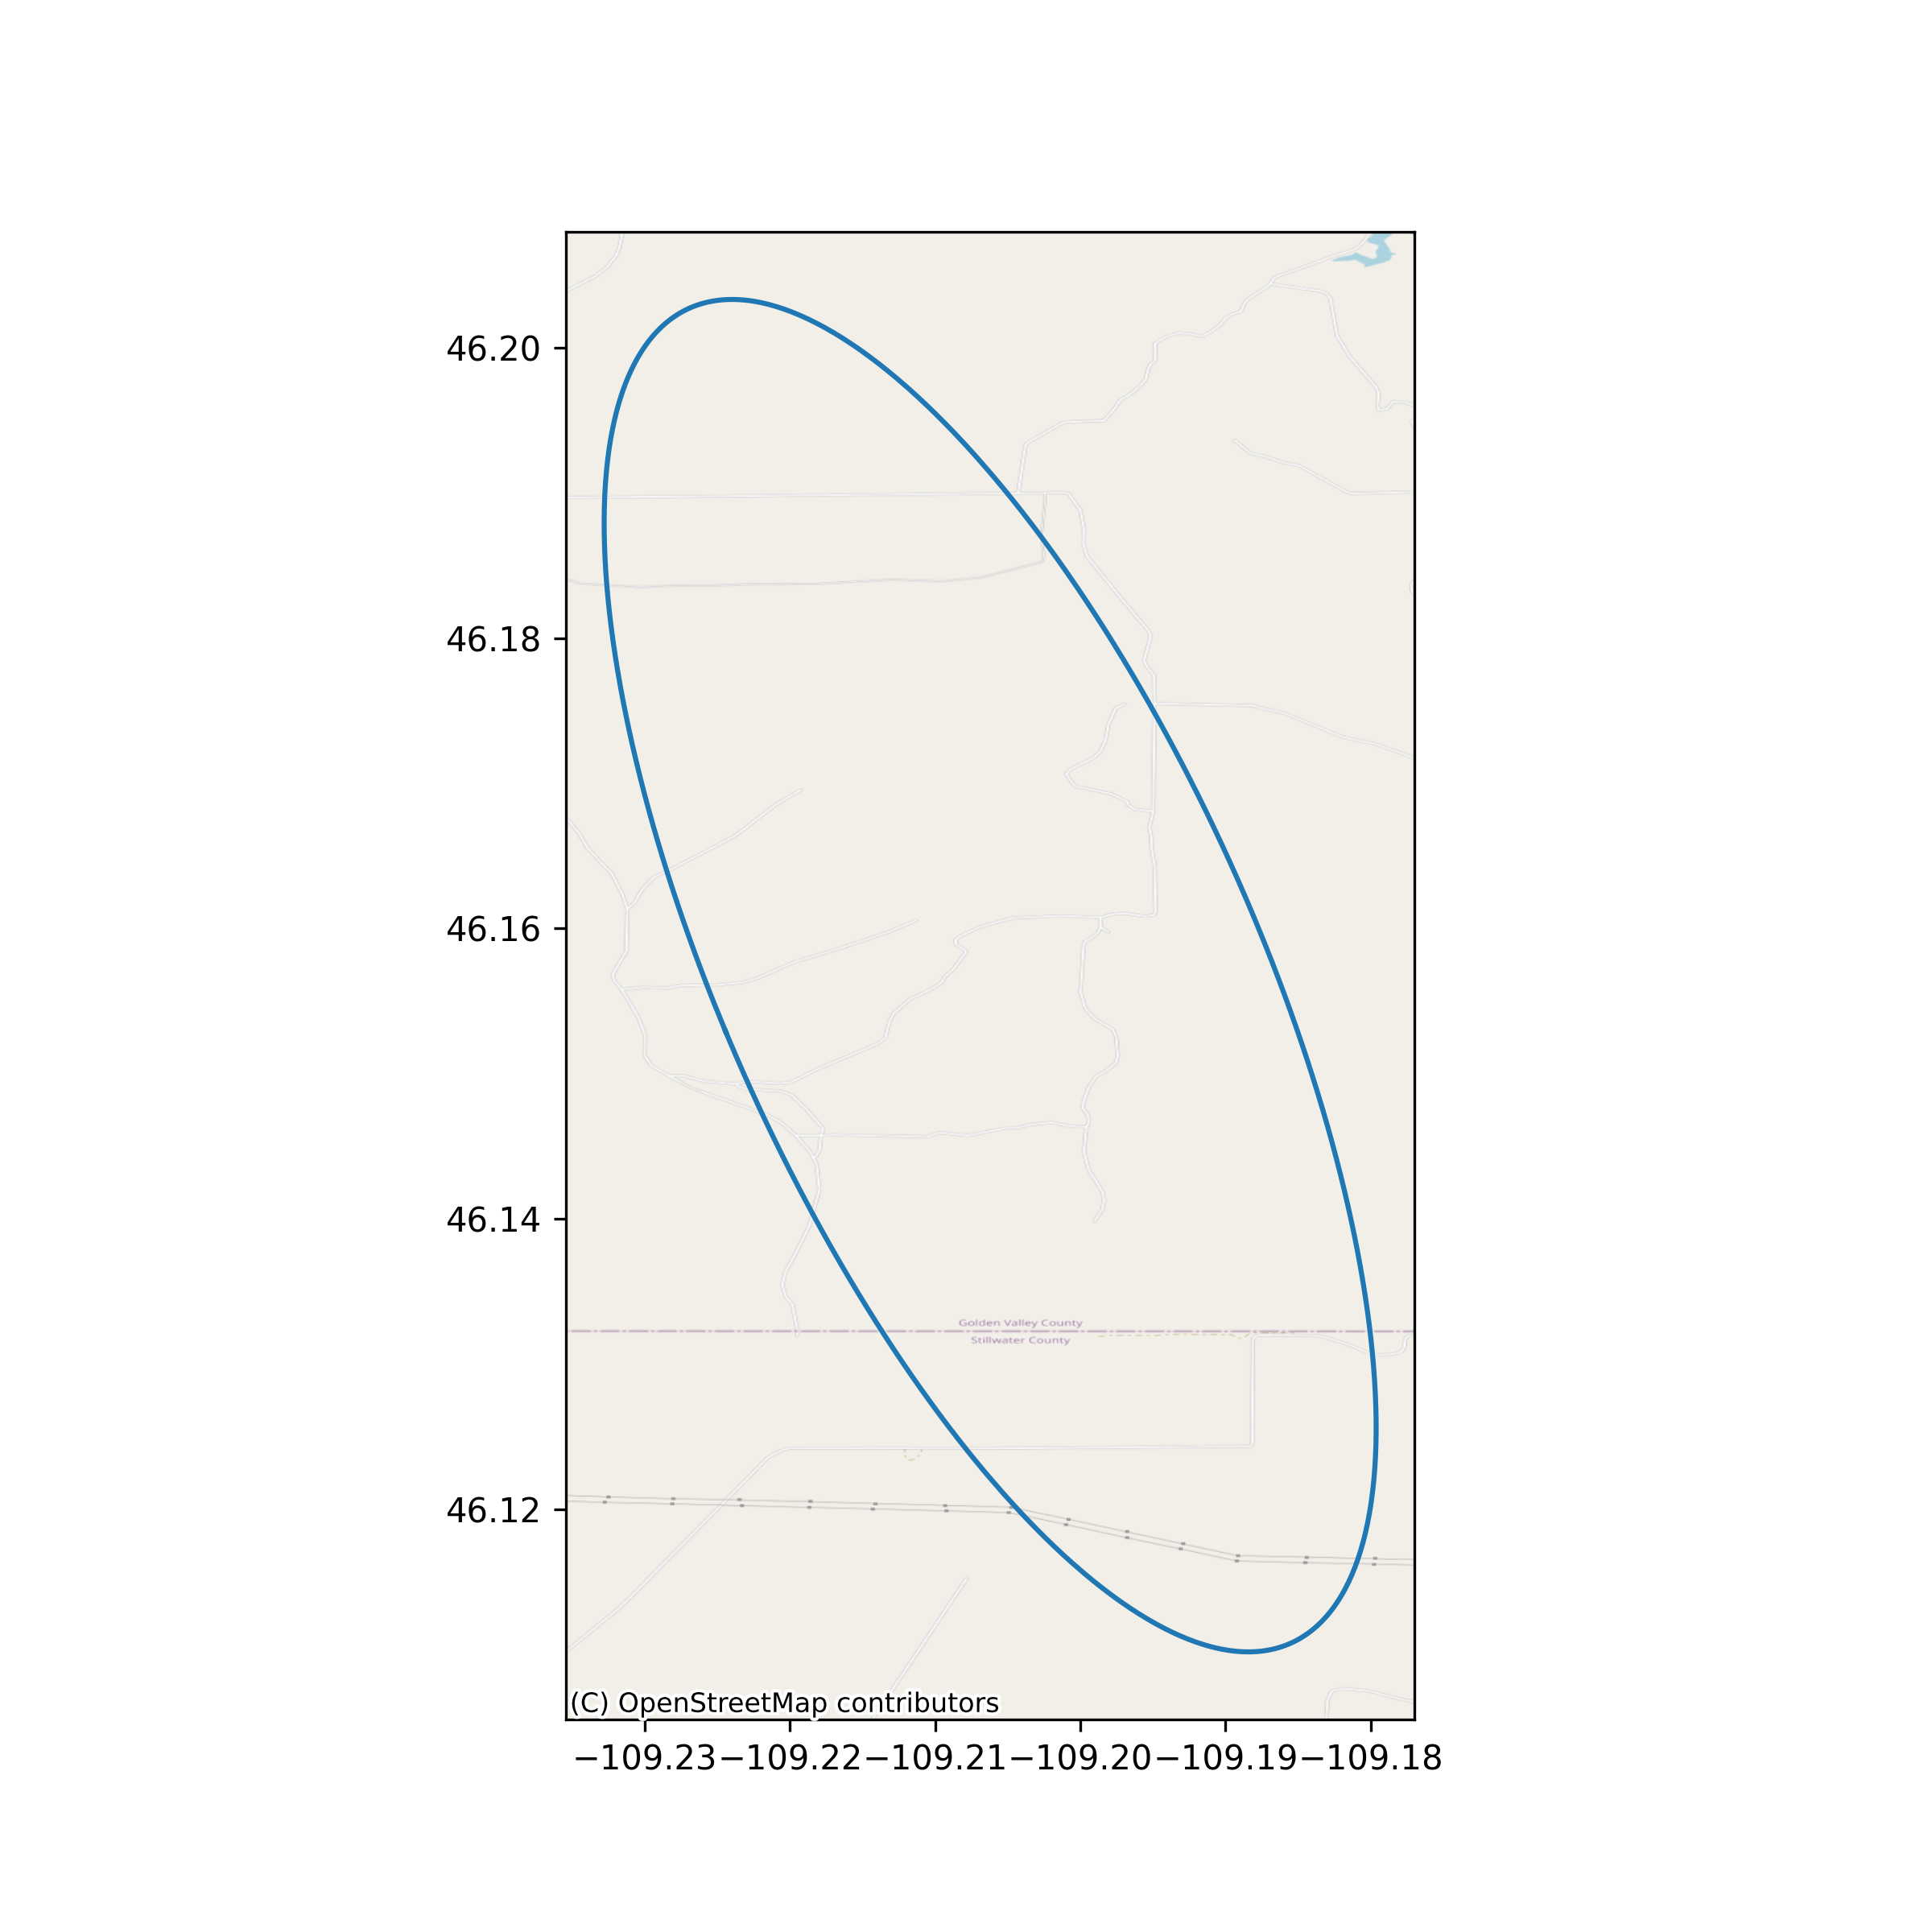

In [55]:
fig, ax = plt.subplots(figsize=(8,8), dpi=300)
el = starepandas.io.granules.modis.make_ellipse(point.x, point.y, width, height, azimuth)
el = starepandas.io.granules.modis.transform(el, 3310, 4326)

ax.plot(*el.xy)

contextily.add_basemap(ax, source=contextily.providers.OpenStreetMap.Mapnik, crs=4326)